In [508]:
import pandas as pd
import numpy as np
import re

import sys

sys.path.append("../src/biblical_scripts/pipelines/data_science")
sys.path.append("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/src")

from AuthorshipAttribution.AuthAttLib import *

from tqdm import tqdm

import logging
logging.basicConfig(level=logging.INFO)

### Load Context

In [509]:
project_dir = "/Users/kipnisal/DS/BiblicalScripts/bib-scripts"
from kedro.framework.session import KedroSession
with KedroSession.create("biblical_scripts", project_path=project_dir) as session:
    ctx = session.load_context()
params = ctx.params

2021-04-19 13:05:42,897 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2021-04-19 13:05:43,235 - kedro.framework.session.store - INFO - `save()` not implemented for `BaseSessionStore`. Skipping the step.


# Distributed

### To Do:
 - Use cross-val pipeline
 - Correct sim_full so that doc-corp comparison is based all data (for the case that we apply feature reduction)
 - ~~Use sim_only pipeline~~
 - Report rank test pval in table
 - Report t-test pval in table


In [481]:
from dask.distributed import Client

In [482]:
client = Client()

# Text Processing

In [483]:
data = ctx.catalog.load('oshb_parsed')

2021-04-19 12:27:33,154 - kedro.io.data_catalog - INFO - Loading data from `oshb_parsed` (CSVDataSet)...


# Accuracy

In [484]:
from biblical_scripts.pipelines.data_science.nodes import report_table

sim_res = pd.read_csv("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/data/07_sim_output/sim_res.csv")

In [68]:
df = sim_res.copy().rename(columns={'true_author' : 'author'})
df['corpus'] = sim_res['variable'].str.extract(r'([^:]+):')


res_tbl = df.pivot('corpus','doc','value')
lo_corpora = df.corpus.unique().tolist()
cmin = res_tbl.idxmin().rename('min_corpus')
res_tbl = res_tbl.append(cmin)
res_tbl.loc['author', :] = [r[1] for r in res_tbl.columns.str.split(' by ')]
res_tbl.loc['succ', :] = res_tbl.loc['min_corpus',:] == res_tbl.loc['author',:]

res_tbl['mean'] = rp.loc[lo_corpora + ['succ'],:].mean(1)
res_tbl

doc,1Chr.12 by Chr1,1Chr.22 by Chr1,1Chr.23 by Chr1,1Chr.24 by Chr1,1Chr.25 by Chr1,1Chr.26 by Chr1,1Chr.27 by Chr1,1Chr.28 by Chr1,1Chr.29 by Chr1,"1Kgs.8 by 12, 1 Kings 8-10; 11:41-43",...,Prov.23 by Prov,Prov.24 by Prov,Prov.25 by Prov,Prov.26 by Prov,Prov.27 by Prov,Prov.28 by Prov,Prov.29 by Prov,Prov.30 by Prov,Prov.31 by Prov,mean
corpus,,,,,,,,,,,,,,,,,,,,,
Dtr,0.672217,1.699666,2.439353,1.800035,1.670793,2.945656,-0.123985,2.904817,2.282725,3.522975,...,-0.763573,0.504632,1.47913,-3.623939,0.547239,-2.993312,-1.250881,-0.196337,-0.402459,0.985860
DtrH,0.163331,2.172532,1.885906,1.079523,0.550403,2.314226,1.181041,2.298424,2.137941,1.184169,...,0.656064,-0.087345,0.954954,-1.280491,0.879631,-2.084898,0.248653,-1.427404,-0.1738,0.745624
P,0.530626,2.371737,2.17593,1.34056,1.673176,1.636214,2.19497,2.635918,3.239808,5.659863,...,1.487273,1.241925,1.258142,0.830113,1.432819,1.368299,0.585248,1.459047,-0.59781,1.836922
min_corpus,DtrH,Dtr,DtrH,DtrH,DtrH,P,Dtr,DtrH,DtrH,DtrH,...,Dtr,DtrH,DtrH,Dtr,Dtr,Dtr,Dtr,DtrH,P,NaN
author,Chr1,Chr1,Chr1,Chr1,Chr1,Chr1,Chr1,Chr1,Chr1,"12, 1 Kings 8-10; 11:41-43",...,Prov,Prov,Prov,Prov,Prov,Prov,Prov,Prov,Prov,NaN
succ,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.341667


# Conversion

In [85]:
data = ctx.catalog.load('oshb_parsed')
from biblical_scripts.extras.Convert import Convert
convert = Convert(data)

2021-04-15 23:53:03,617 - kedro.io.data_catalog - INFO - Loading data from `oshb_parsed` (CSVDataSet)...


In [86]:
convert.to_term('7628')

'7628'

In [93]:
data[data.lemma.str.contains("5137")]

,chapter,lemma,morph,term,verse,author
10493,2Kgs.9,c/5137 a,HC/Vqw3ms,וַ/יִּ֨ז,2Kgs.9.33,"18, 2 Kings 8:25-11:3"
49550,Exod.29,c/5137 a,HC/Vhq2ms,וְ/הִזֵּיתָ֤,Exod.29.21,P
56872,Lev.4,c/5137 a,HC/Vhq3ms,וְ/הִזָּ֨ה,Lev.4.6,P
57051,Lev.4,c/5137 a,HC/Vhq3ms,וְ/הִזָּ֞ה,Lev.4.17,P
57471,Lev.8,c/5137 a,HC/Vhw3ms,וַ/יַּ֥ז,Lev.8.11,P
57801,Lev.8,c/5137 a,HC/Vhw3ms,וַ/יַּ֤ז,Lev.8.30,P


In [939]:
vocab = pd.read_csv("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/data/05_model_input/vocabulary.csv")

In [1025]:
from sklearn.model_selection import KFold

In [961]:
vocab.loc[1,'feature']

"('c', '<Np>')"

# Sim full  

In [127]:
sim_full_res_large = pd.read_csv(project_dir + "/data/07_sim_output/sim_full_res_large.csv")

In [524]:
sim_full_res = cnx.catalog.load("sim_full_res")
print("len res = ",len(sim_full_res))

2021-04-19 13:07:24,380 - kedro.io.data_catalog - INFO - Loading data from `sim_full_res` (CSVDataSet)...
len res =  6342


## Results:

In [511]:
import plotnine
plotnine.options.figure_size = (10, 6)
from plotnine import *
logging.basicConfig(level=logging.INFO)

In [512]:
from biblical_scripts.pipelines.report.nodes import (_prepare_res, report_table_full,
                                                     report_sim)


In [649]:
def _arrange_metadata(df, value) :
    """
    adds 'corpus' and 'author' column to evaluation results
    """
    
    df = df[df.variable.str.contains(value)]
    df.loc[:,'corpus'] = sim_full_res.variable.str.extract(rf"(^[A-Za-z0-9 ]+)(-ext)?:([A-Za-z]+)")[0]
    df.loc[:,'author'] = df.doc_tested.str.extract(r"by (.+)")[0]
    return df


In [657]:
def _comp_probs(sim_full_res : pd.DataFrame, by) -> pd.DataFrame :
    """
    mean, std and CI's over many iterations.
    """
    
    df.loc[:,'rank'] = np.floor(df.groupby(by)['value'].transform('rank'))

    df0 = df[df.kind == 'org']
    df1 = df[df.kind != 'org']

    #df1['corpus'] = df1['corpus'].str.extract(r'([A-Za-z0-9 ]+)-ext')[0]
    grp = df1.groupby(by)
    res = grp.agg({value : ['mean', 'std', 'count', 
                               lambda x : pd.Series.quantile(x, q=.05),
                               lambda x : pd.Series.quantile(x, q=.95)
                              ]}, as_index=False).reset_index()\
        .rename(columns = {'<lambda_0>' : 'CI05', '<lambda_1>' : 'CI95'})

    dfm = df0.merge(res[['doc_tested', 'corpus', 'value']],
                      on=['doc_tested', 'corpus'], how='right')

    mu = dfm[(value, 'mean')]
    std = dfm[(value ,'std')]
    n = dfm[(value, 'count')]

    dfm.loc[:,'prob'] = 1 - (np.floor(dfm['rank'])-1) / n
    dfm.loc[:,'t-score'] = np.abs(dfm[value] - mu) / (std * np.sqrt(n/(n-1)))
    dfm.loc[:,'t-test'] = scipy.stats.t.sf(dfm['t-score'], df=n-1)
    return dfm

def comp_probs(sim_full_res, params_report) :
    df = _arrange_metadata(sim_full_res, value=params_report['value'])
    dfm = _comp_probs(df, by = ['author', 'doc_tested', 'corpus'])
    return dfm
    
def report_probs(dfm)
    return dfm.pivot('corpus', 'doc_tested', ['value', 'prob', 't-test', 'rank', 't-score'])

In [671]:
res = comp_probs(sim_full_res, params_report = params['report'])
res.to_csv('temp.csv')

/usr/local/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
/usr/local/lib/python3.8/site-packages/pandas/core/generic.py:4152: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.


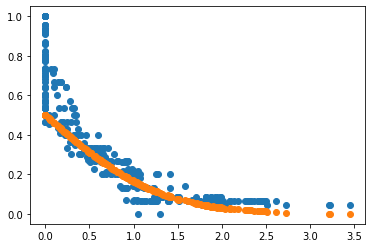

In [656]:
plt.scatter(dfm['t-score'], dfm['prob'])
plt.scatter(dfm['t-score'], dfm['t-test'])
plt.show()

/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr

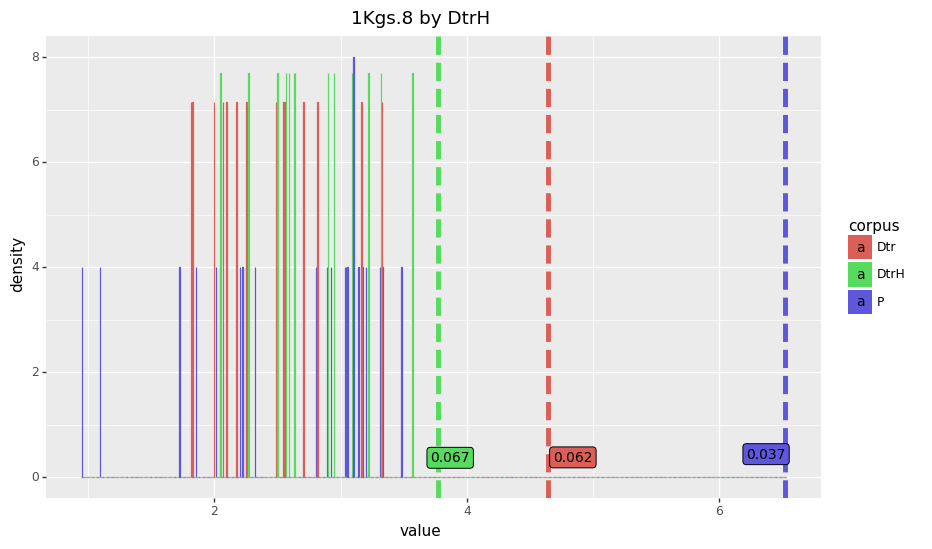

<ggplot: (343879762)>


In [1537]:
p = (ggplot(aes(x='value', fill = 'corpus', y='..density..',
            color='corpus', label='corpus'), data = res1_null)
         + geom_histogram(alpha=0.3,position='dodge', binwidth=.01) 
         #+ geom_density(alpha = 0.5)
         + geom_vline(aes(xintercept='value', color='corpus'),
                      data=res1_doc, size=2, linetype='dashed')
         + geom_label(data=res1_doc,
                          mapping=aes(x='value', y=0.5, label='prob', fill='corpus'),
                          position=position_jitter(),
                          size=10, colour = "black")
         + ggtitle('{}'.format(doc_nm)) )

#p.save('./Figs/simulated_null_{}_NG{}_temp.png'.format(auth,NG_RANGE))
print(p)


# Models

In [1092]:
data_proc = pd.read_csv(path + '/' + 'data/04_feature/data_proc.csv')

In [880]:
import pandas as pd
import numpy as np
import logging
%reload_ext autoreload
from biblical_scripts.pipelines.data_science.AuthorshipAttribution.AuthAttLib import AuthorshipAttributionDTM
from biblical_scripts.pipelines.data_science.AuthorshipAttribution.MultiDoc import CompareDocs
from biblical_scripts.pipelines.data_science.nodes import (build_vocab, compute_sim)
#%load_ext autoreload
#%autoreload 2

data_raw = pd.read_csv(path + '/' + 'data/02_intermediate/oshd_parsed.csv')
data_proc = pd.read_csv(path + '/' + 'data/04_feature/data_proc.csv')
#vocab = pd.read_csv(path + '/' + 'data/05_model_input/vocabulary.csv')
vocab = build_vocab(data_proc, parameters['vocab'], parameters['known_authors'])

INFO:root:Constructed vocabulary with 960 features


In [878]:
def compute_sim(data, vocabulary, params, known_authors) :
    ds = data.rename(columns = {'feature' : 'term', 'chapter' : 'doc_id'}).dropna()
    model = AuthorshipAttributionDTM(ds, params, vocab=listb(vocabulary.feature.values))
    return model.compute_inter_similarity(LOO = True, wrt_authors=known_authors)

In [ ]:
params = {}; [params.update(p) for p in parameters['model']]

md = CompareDocs(vocabulary=vocab.feature.tolist())
#ds=data_proc[['author', 'feature', 'token_id']].groupby(['author', 'feature']).count().reset_index()
ds=data_proc[['author', 'feature', 'token_id', 'chapter']]
ds=ds.rename(columns = {'chapter' : 'doc_id'})
ds['doc_id'] += ' by '
ds['doc_id'] += ds['author'] #sometimes there are multiple authors per chapter
    
known_authors = parameters['known_authors']
train_data = {}
for auth in known_authors :
    train_data[auth] = ds[ds.author==auth]

md.fit(train_data)
df_res1 = pd.DataFrame()
for doc_id in ds.doc_id.unique() :
    tested_doc = ds[ds.doc_id==doc_id]
    auth = tested_doc.author.values[0]
    df_rec = md.test_doc(tested_doc, of_cls = auth)
    r = df_rec.iloc[:,df_rec.columns.str.contains(r'HC|Fisher|chisq')].mean()
    r['doc_id'] = doc_id
    r['author'] = auth
    r['len'] = len(tested_doc)
    df_res1 = df_res1.append(r, ignore_index=True)

In [932]:
df = df_res1.melt(['author', 'doc_id', 'len'])

def _eval_succ(df) :
    df['wrt_author'] = df['variable'].str.extract(r'([^:]+):')
    idx_min = df.groupby(['doc_id', 'author'])['value'].idxmin()
    res_min = df.loc[idx_min, :].rename(columns={'wrt_author' : 'most_sim'})
    res_min.loc[:, 'succ'] = res_min.author == res_min.most_sim
    return res_min

value = report_params['value']
df1 = df[df['variable'].str.contains(f":{value}")]
df1 = df1[df1.author.isin(known_authors)].reset_index()

res = _eval_succ(df1)
res['acc'] = res.succ.mean()
res['param'] = str(parameters)

In [935]:
ds = pd.read_csv("../data/05_model_input/vocabulary.csv")
ds[~ds.feature.str.contains(r"\[[a-zA-Z0-9]+\]")]

,feature
0,103
1,1086
2,1104
3,1115
4,1129
...,...
636,8484
637,8519
638,8535
639,887


In [876]:
data_raw[data_raw.chapter == '2Kgs.23']

array(['21, 2 Kings 23 :21-30', 'DtrH'], dtype=object)

# Feature Selection

In [763]:
import pandas as pd
import numpy as np
import logging
%reload_ext autoreload
from biblical_scripts.pipelines.data_science.AuthorshipAttribution.AuthAttLib import AuthorshipAttributionDTM
from biblical_scripts.pipelines.data_science.AuthorshipAttribution.MultiDoc import CompareDocs
from biblical_scripts.pipelines.data_science.nodes import (build_vocab, compute_sim)
#%load_ext autoreload
#%autoreload 2

In [764]:
#data:
data_proc = pd.read_csv(path + '/' + 'data/04_feature/data_proc.csv')
vocab = build_vocab(data_proc, parameters['vocab'], parameters['known_authors'])

INFO:root:Constructed a vocabulary of 960 features


In [ ]:
# using discriminating features

md = CompareDocs(vocabulary=vocab.feature.to_list())
#ds=data_proc[['author', 'feature', 'token_id']].groupby(['author', 'feature']).count().reset_index()
ds=data_proc[['author', 'feature', 'token_id']]

Dtr = ds[ds.author=='Dtr']
DtrH = ds[ds.author=='DtrH']
P = ds[ds.author=='P']

md.fit({'Dtr' : Dtr, 'DtrH' : DtrH, 'P' : P})
df_disc = md.HCT(stbl=True)
feat = df_disc[df_disc.thresh].index.to_list()
terms = [convert.to_term(f) for f in feat]

In [ ]:
ds = data_proc.drop('term', axis=1).rename(columns = {'chapter' : 'doc_id', 'feature' : 'term'}).dropna()
ds_red = ds[ds.term.isin(feat)]
ds_red[ds_red.groupby('doc_id').term.transform(pd.Series.count)>0]
knwon_authors = parameters['known_authors']
model = AuthorshipAttributionDTM(ds_red, **param, vocab=feat)
df_res=model.compute_inter_similarity(LOO = True, wrt_authors=known_authors)

In [773]:
md = CompareDocs(vocabulary=feat)
#ds=data_proc[['author', 'feature', 'token_id']].groupby(['author', 'feature']).count().reset_index()
ds=data_proc[['author', 'feature', 'token_id', 'chapter']]
ds=ds.rename(columns = {'chapter' : 'doc_id'})

known_authors = parameters['known_authors']
train_data = {}
for auth in known_authors :
    train_data[auth] = ds[ds.author==auth]

md.fit(train_data)
df_res1 = pd.DataFrame()
for doc_id in ds.doc_id.unique() :
    tested_doc = ds[ds.doc_id==doc_id]
    auth = tested_doc.author.values[0]
    df_rec = md.test_doc(tested_doc, of_cls = auth)
    r = df_rec.iloc[:,df_rec.columns.str.contains(r'HC|Fisher|chisq')].mean()
    r['doc_id'] = doc_id
    r['author'] = auth
    r['len'] = len(tested_doc)
    df_res1 = df_res1.append(r, ignore_index=True)

DEBUG:root:Processing Dtr...
DEBUG:root:Found 2048 terms.
DEBUG:root:Processing DtrH...
DEBUG:root:Found 2457 terms.
DEBUG:root:Processing P...
DEBUG:root:Found 4179 terms.
DEBUG:root:Doc contains 49.0 terms.
DEBUG:root:Doc contains 119.0 terms.
DEBUG:root:Doc contains 68.0 terms.
DEBUG:root:Doc contains 65.0 terms.
DEBUG:root:Doc contains 60.0 terms.
DEBUG:root:Doc contains 74.0 terms.
DEBUG:root:Doc contains 109.0 terms.
DEBUG:root:Doc contains 175.0 terms.
DEBUG:root:Doc contains 71.0 terms.
DEBUG:root:Doc contains 92.0 terms.
DEBUG:root:Doc contains 175.0 terms.
DEBUG:root:Doc contains 124.0 terms.
DEBUG:root:Doc contains 93.0 terms.
DEBUG:root:Doc contains 62.0 terms.
DEBUG:root:Doc contains 57.0 terms.
DEBUG:root:Doc contains 84.0 terms.
DEBUG:root:Doc contains 91.0 terms.
DEBUG:root:Doc contains 159.0 terms.
DEBUG:root:Doc contains 115.0 terms.
DEBUG:root:Doc contains 136.0 terms.
DEBUG:root:Doc contains 16.0 terms.
DEBUG:root:Doc contains 132.0 terms.
DEBUG:root:Doc contains 59

ValueError: All values in `observed` must be nonnegative.

In [793]:
df_eval = df_res1.melt(['author', 'doc_id', 'len'])
df_eval.head(3)

,author,doc_id,len,variable,value
0,"1, 1 Chron 10",1Chr.10,315.0,Dtr:Fisher,140.932326
1,"2, 1 Chron 11",1Chr.11,761.0,Dtr:Fisher,266.941973
2,Chr1,1Chr.12,387.0,Dtr:Fisher,227.374529


In [792]:
df1 = df[df['variable'].str.contains(f":{value}")]
df1.head(3)

,author,doc_id,len,variable,value,wrt_author
63,"1, 1 Chron 10",1Chr.10,315.0,Dtr:HC,1.161644,Dtr
64,"2, 1 Chron 11",1Chr.11,761.0,Dtr:HC,1.367914,Dtr
65,Chr1,1Chr.12,387.0,Dtr:HC,1.858160,Dtr


In [832]:
known_authors = parameters['known_authors']
report_params = parameters['report']
value = report_params['value']
df = df_eval

#def evaluate_accuracy(df : pd.DataFrame, known_authors : List, report_params, parameters) -> float :
def _eval_acc(df) :
    df['wrt_author'] = df['variable'].str.extract(r'([^:]+):')
    idx_min = res1.groupby(['doc_id', 'author'])['value'].idxmin()
    res_min = res1.loc[idx_min, :]
    res_min.loc[:, 'succ'] = res_min.author == res_min.wrt_author
    succ_per_doc = res_min.groupby('doc_id').succ.mean()
    return succ_per_doc.mean()

value = report_params['value']
df1 = df[df['variable'].str.contains(f":{value}")]
df1 = df1[df1.author.isin(known_authors)].reset_index()

acc = _eval_acc(df1)

#rep['param'] = parameters
return pd.DataFrame({'acc' : acc}, index=[parameters])


                                                         acc
{'preprocessing': {'extract_prefix': True, 'ext...  0.638554


In [830]:
df1

,index,author,doc_id,len,variable,value,wrt_author
0,124,DtrH,2Kgs.17,520.0,Dtr:HC,2.220364,Dtr
1,125,DtrH,2Kgs.22,568.0,Dtr:HC,3.010700,Dtr
2,313,DtrH,2Kgs.17,520.0,DtrH:HC,0.643856,DtrH
3,314,DtrH,2Kgs.22,568.0,DtrH:HC,1.272487,DtrH
4,502,DtrH,2Kgs.17,520.0,P:HC,3.731762,P
5,503,DtrH,2Kgs.22,568.0,P:HC,3.273535,P


TypeError: reduction operation 'argmin' not allowed for this dtype

In [741]:
df

,author,doc_id,len,variable,value,wrt_author
0,"1, 1 Chron 10",1Chr.10,315.0,HC (Dtr),1.161644,Dtr
1,"2, 1 Chron 11",1Chr.11,761.0,HC (Dtr),1.367914,Dtr
2,Chr1,1Chr.12,387.0,HC (Dtr),1.858160,Dtr
3,"3, 1 Chron 13",1Chr.13,314.0,HC (Dtr),-0.623731,Dtr
4,"4, 1 Chron 14",1Chr.14,309.0,HC (Dtr),1.358312,Dtr
...,...,...,...,...,...,...
577,Prov,Prov.27,316.0,HC (P),2.561318,P
578,Prov,Prov.28,304.0,HC (P),2.202612,P
579,Prov,Prov.29,269.0,HC (P),2.896388,P
580,Prov,Prov.30,412.0,HC (P),3.781481,P


In [687]:
def eval_accuracy(df, known_authors) :
    res1 = df[df.author.isin(known_authors) & df.wrt_author.isin(known_authors)].reset_index()
    idx_min = res1.groupby(['doc_id', 'author'])['value'].idxmin()
    res_min = res1.loc[idx_min, :]
    res_min.loc[:, 'succ'] = res_min.author == res_min.wrt_author

    succ_per_doc = res_min.groupby('doc_id').succ.mean()
    return succ_per_doc.mean()

df_eval = df_res1.melt(['author', 'doc_id'])
df_eval['wrt_author'] = df_eval['variable'].str.extract(r'HC \((.+)\)')
eval_accuracy(df_eval, known_authors)

0.6385542168674698

In [691]:
eval_accuracy(df_res.rename(columns={'HC' : 'value'}), known_authors)

0.5471698113207547

In [680]:
df_res['len'] = 1000
evaluate_accuracy(df_res, known_authors, 'HC', "")

TypeError: Invalid comparison between dtype=int64 and str

In [677]:
def evaluate_accuracy(df_res: pd.DataFrame, known_authors, min_length_to_report : int, params) -> pd.DataFrame :
    """
    Evaluate accuracy of attribution in min discrepancy manner
    
    Args:
    min_length_to_report    only try to attribute docs of length larger than that
    known_authors           only compare against corpora from this list
    
    Returns:
    average accuracy for each similarity measure
    """
    def prob_of_succ(df, value, known_authors, min_length=min_length_to_report, plot=False) :
        df = df[df.len >= min_length]
        df.loc[:,value] = df[value].astype(float)
        res1 = df[df.author.isin(known_authors) & df.wrt_author.isin(known_authors)].reset_index()
        idx_min = res1.groupby(['doc_id', 'author'])[value].idxmin()
        res_min = res1.loc[idx_min, :]
        res_min.loc[:, 'succ'] = res_min.author == res_min.wrt_author

        succ_per_doc = res_min.groupby('doc_id').succ.mean()
        return succ_per_doc.mean()

    res = {}
    for v in ['HC', 'HC_rank', 'chisq', 'chisq_rank', 'log-likelihood','log-likelihood_rank', 'Fisher']  :
        res[v] = prob_of_succ(df_res, value = v, known_authors=known_authors)
        
    res['params'] = str(params)
    return pd.DataFrame(res, index=[0])
